<a href="https://colab.research.google.com/github/hafnailmy-bip/pertemuan2/blob/main/PCD_Tugas_Model_Warna_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload at least 3 images of the same object with different lighting


Saving Foto Model Warna Normal.jpeg to Foto Model Warna Normal (1).jpeg
Saving Foto Model Warna Redup.jpeg to Foto Model Warna Redup (1).jpeg
Saving Foto Model Warna Terang.jpeg to Foto Model Warna Terang (1).jpeg
===== IMAGE 1 =====
Conversion Time: 0.0015 seconds


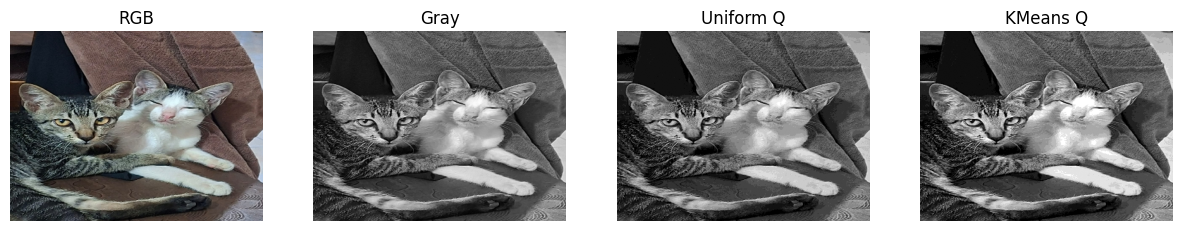

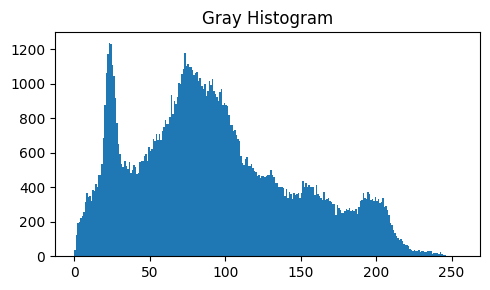

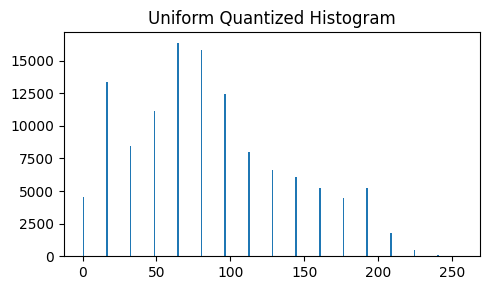

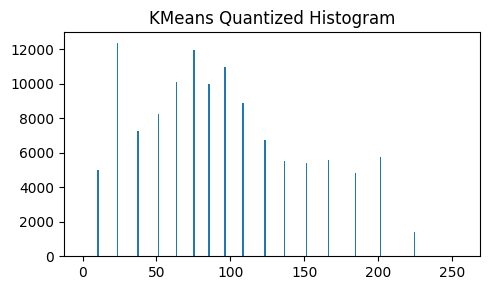

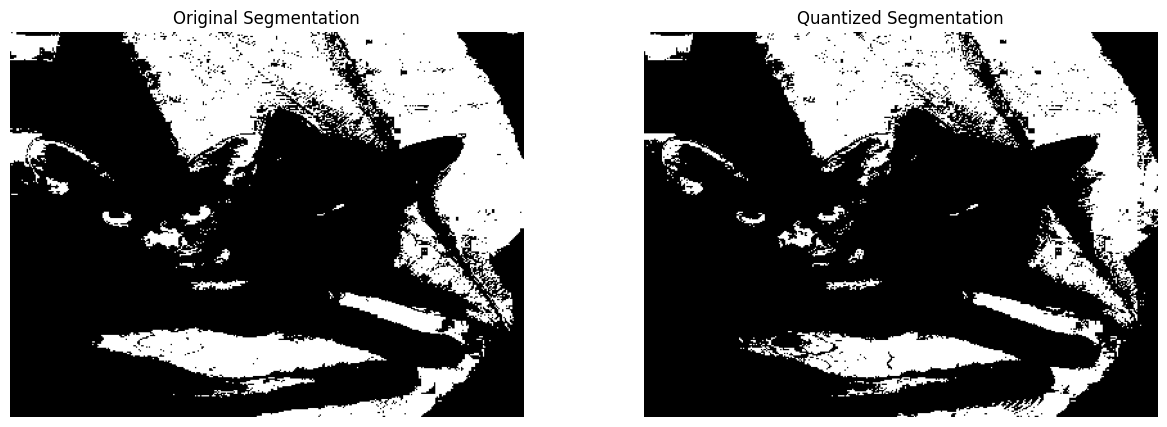

Memory Original (KB): 351.56
Estimated Quantized Size (KB): 175.78
Compression Ratio: 2.0

===== IMAGE 2 =====
Conversion Time: 0.0027 seconds


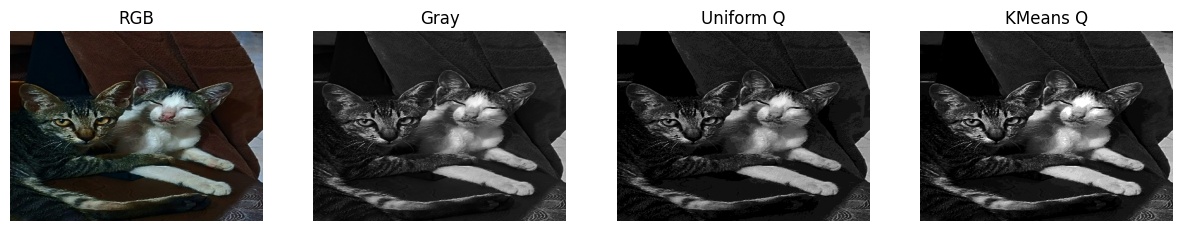

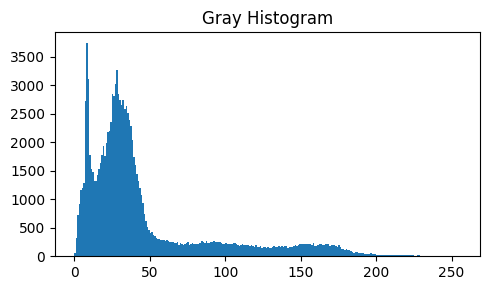

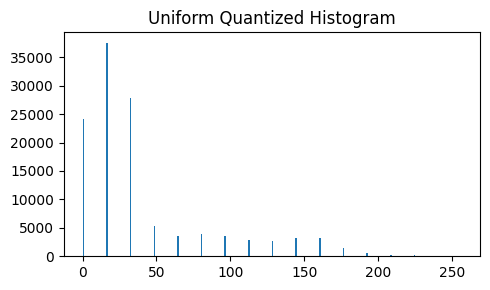

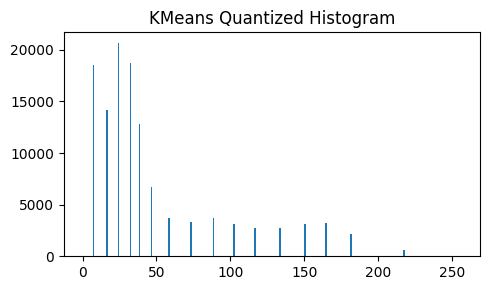

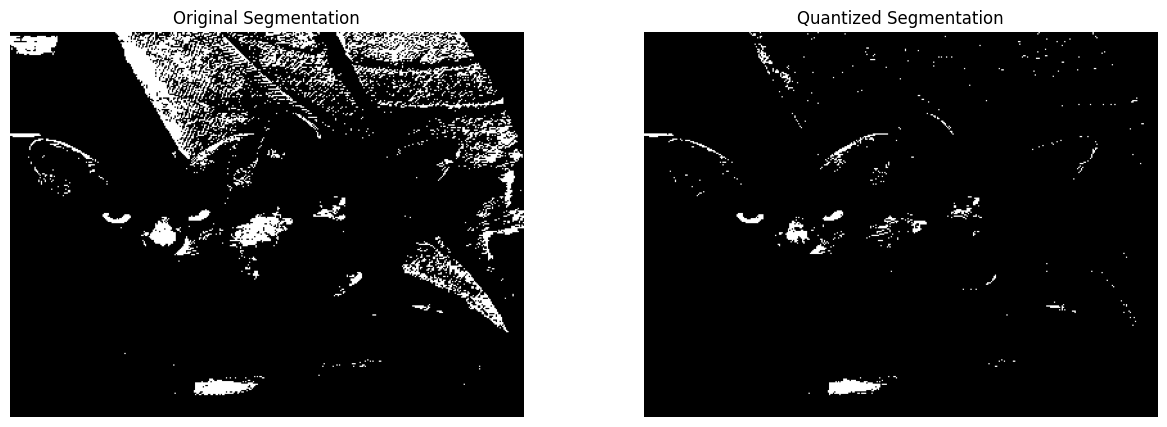

Memory Original (KB): 351.56
Estimated Quantized Size (KB): 175.78
Compression Ratio: 2.0

===== IMAGE 3 =====
Conversion Time: 0.0031 seconds


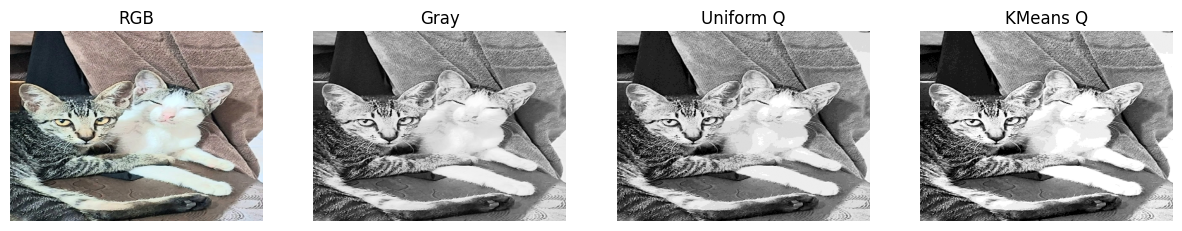

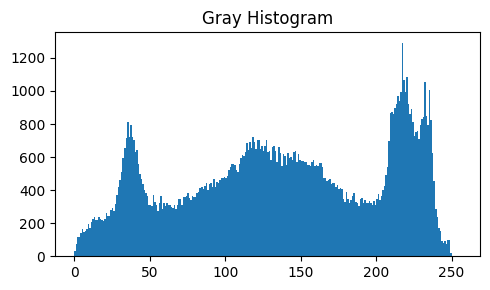

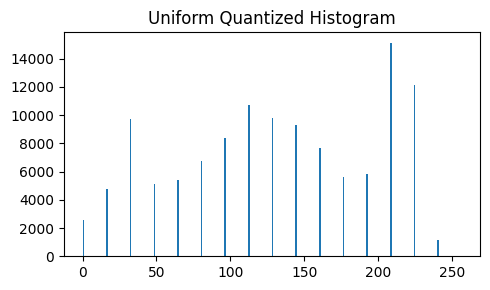

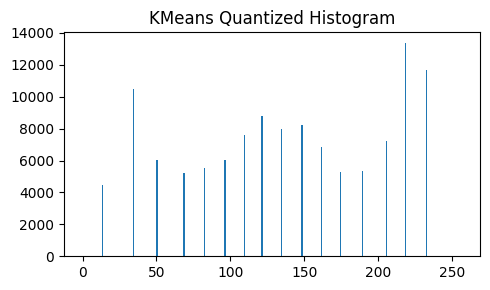

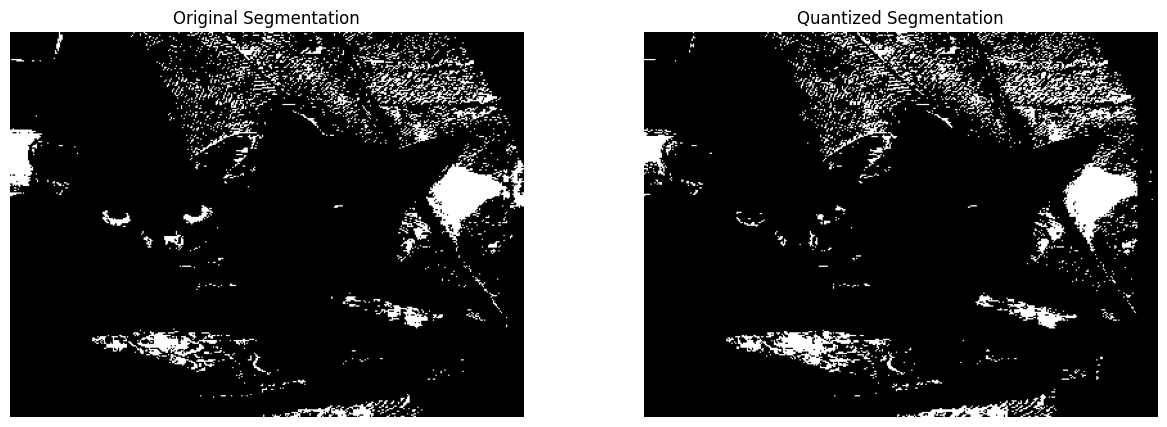

Memory Original (KB): 351.56
Estimated Quantized Size (KB): 175.78
Compression Ratio: 2.0



In [4]:
# ============================================================
# Fixed Version — Google Colab Compatible & Stable
# ============================================================

!pip -q install opencv-python scikit-learn

import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from google.colab import files

plt.rcParams['figure.figsize'] = (12,6)

# =============================
# Upload Images
# =============================
print("Upload at least 3 images of the same object with different lighting")
uploaded = files.upload()

image_paths = list(uploaded.keys())
images = []

for p in image_paths:
    img = cv2.imread(p)
    if img is None:
        print(f"Failed to load {p}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(400,300))  # prevent KMeans crash (too many pixels)
    images.append(img)

# =============================
# Utility
# =============================

def show_images(img_list, titles):
    plt.figure(figsize=(15,5))
    for i,(img,title) in enumerate(zip(img_list,titles)):
        plt.subplot(1,len(img_list),i+1)
        if len(img.shape)==2:
            plt.imshow(img,cmap='gray')
        else:
            plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()


def memory_size(img):
    return img.nbytes/1024


def estimated_quantized_size(img,levels=16):
    bits=int(np.log2(levels))
    pixels=img.size
    return pixels*bits/8/1024

# =============================
# Color Conversion
# =============================

def convert_color_spaces(img):
    start=time.time()
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hsv=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    lab=cv2.cvtColor(img,cv2.COLOR_RGB2LAB)
    return gray,hsv,lab,time.time()-start

# =============================
# Uniform Quantization
# =============================

def uniform_quantization(img,levels=16):
    step=256//levels
    return ((img//step)*step).astype(np.uint8)

# =============================
# KMeans Quantization (FAST)
# =============================

def kmeans_quantization(img,k=16,sample=5000):
    data = img.reshape((-1,1)) if len(img.shape)==2 else img.reshape((-1,3))
    data = np.float32(data)

    # sample pixels to prevent crash
    if len(data) > sample:
        idx=np.random.choice(len(data),sample,replace=False)
        train=data[idx]
    else:
        train=data

    kmeans=KMeans(n_clusters=k,n_init=3,random_state=0).fit(train)
    centers=np.uint8(kmeans.cluster_centers_)

    labels=kmeans.predict(data)
    res=centers[labels]
    return res.reshape(img.shape)

# =============================
# Histogram
# =============================

def plot_histogram(img,title):
    plt.figure(figsize=(5,3))
    if len(img.shape)==2:
        plt.hist(img.ravel(), bins=256, range=(0,256))
    else:
        for i in range(3):
            plt.hist(img[:,:,i].ravel(), bins=256, range=(0,256), alpha=0.4)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

# =============================
# HSV Segmentation (SAFE)
# =============================

def hsv_segmentation_from_rgb(img_rgb):
    hsv=cv2.cvtColor(img_rgb,cv2.COLOR_RGB2HSV)
    lower=np.array([0,50,50])
    upper=np.array([30,255,255])
    return cv2.inRange(hsv,lower,upper)

# =============================
# Processing
# =============================
for idx,img in enumerate(images):
    print(f"===== IMAGE {idx+1} =====")

    gray,hsv,lab,conv_time=convert_color_spaces(img)
    print("Conversion Time:",round(conv_time,4),"seconds")

    uq_gray=uniform_quantization(gray)
    uq_hsv=uniform_quantization(hsv)

    kq_gray=kmeans_quantization(gray)

    show_images([img,gray,uq_gray,kq_gray],["RGB","Gray","Uniform Q","KMeans Q"])
    plt.close('all')

    plot_histogram(gray,"Gray Histogram")
    plot_histogram(uq_gray,"Uniform Quantized Histogram")
    plot_histogram(kq_gray,"KMeans Quantized Histogram")

    mask_original=hsv_segmentation_from_rgb(img)
    mask_quant=hsv_segmentation_from_rgb(cv2.cvtColor(uq_hsv,cv2.COLOR_HSV2RGB))

    show_images([mask_original,mask_quant],["Original Segmentation","Quantized Segmentation"])
    plt.close('all')

    original_size=memory_size(img)
    quant_size=estimated_quantized_size(img,16)

    print("Memory Original (KB):",round(original_size,2))
    print("Estimated Quantized Size (KB):",round(quant_size,2))
    print("Compression Ratio:",round(original_size/quant_size,2))
    print()
